In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Note that each chunk can be run independently. This means that library imports may be redundant with a full run through and train test splits are not mirrored across methods. This is done to faciliate debugging and development.

# Baseline Models

### SVM

In [2]:
from sklearn.datasets import load_files
import cv2
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

In [3]:
# Load data
datapath = 'data'
dataset = load_files(datapath, load_content=False, shuffle=True)
dataset

{'filenames': array(['data\\1\\verymild_889.jpg', 'data\\0\\non_830.jpg',
        'data\\1\\verymild_2145.jpg', ..., 'data\\0\\non_2487.jpg',
        'data\\0\\non_465.jpg', 'data\\0\\non_578.jpg'], dtype='<U24'),
 'target_names': ['0', '1'],
 'target': array([1, 0, 1, ..., 0, 0, 0]),
 'DESCR': None}

In [4]:
# Read image files as grayscale
X = []
for file in dataset['filenames']:
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = img.flatten()
    X.append(img)
X = np.array(X)
X.shape

(6400, 16384)

In [5]:
# Use default PCA method
pca=PCA()
X = pca.fit_transform(X)
X.shape

(6400, 6400)

In [6]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, dataset['target'])

In [7]:
# Fit a model with default slack C=5
svm_mdl = svm.SVC(C=5)
svm_mdl.fit(X_train, y_train)

SVC(C=5)

In [8]:
# Predict
preds = svm_mdl.predict(X_test)
print(f'Precision: {precision_score(preds, y_test)}\nRecall: {recall_score(preds, y_test)}\nF1: {f1_score(preds, y_test)}')

Precision: 1.0
Recall: 0.9974160206718347
F1: 0.9987063389391979


In [9]:
# Perform k-fold cross validation to determine best slack parameter (5)
# WARNING - EXTREMELY LONG RUNTIME #
#svm_tune = svm.SVC()
#param_dict = {'C': [0.25, 0.5, 1, 2, 5]}
#clf = GridSearchCV(svm_tune, param_dict, scoring='f1')
#clf.fit(X_train, y_train)

### ResNet

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.models import resnet18
import time

In [11]:
# Select device for training (Install cuda toolkit)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
# Load images
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset
data = datasets.ImageFolder('data/', transform=transform)

# Split into training and test sets
train_size = int(0.75 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])

In [13]:
# Define ResNet18
model = resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(data.classes))

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.0001)

In [15]:
# Model Training
num_epochs = 10
batch_size = 40

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

train_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_count = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)

        # Loss computation
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_count += images.size(0)
        
    # Print training loss
    train_loss /= train_count
    train_losses.append(train_loss)
    print('Epoch {} | Avg Training Loss: {:.4f}'.format(epoch+1, train_loss))

end_time = time.time()

print('Total training time: {:.4f}'.format(end_time - start_time))

Epoch 1 | Avg Training Loss: 0.6895
Epoch 2 | Avg Training Loss: 0.6578
Epoch 3 | Avg Training Loss: 0.6483
Epoch 4 | Avg Training Loss: 0.6310
Epoch 5 | Avg Training Loss: 0.6484
Epoch 6 | Avg Training Loss: 0.6220
Epoch 7 | Avg Training Loss: 0.6053
Epoch 8 | Avg Training Loss: 0.5960
Epoch 9 | Avg Training Loss: 0.5979
Epoch 10 | Avg Training Loss: 0.5981
Total training time: 1144.7622


In [16]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model.eval()

preds = np.array([])
y = np.array([])

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)

        p = outputs.argmax(dim=1, keepdim=True)
        
        preds = np.concatenate((preds, p.numpy().flatten()))
        y = np.concatenate((y, labels.numpy().flatten()))

precision = precision_score(preds, y)
recall = recall_score(preds, y)
f1 = f1_score(preds, y)

In [17]:
print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Precision: 0.43101182654402104
Recall: 0.6776859504132231
F1: 0.5269076305220883


# Experiment NN

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.models import resnet18
import time

In [19]:
# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
# Load images
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset
data = datasets.ImageFolder('data/', transform=transform)

# Split into training and test sets
train_size = int(0.75 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])

# Further split into training and val sets
train_size = int(0.75 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

In [21]:
# Define netowrk architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=(1,1))
        self.conv2 = nn.Conv2d(12, 18, kernel_size=(2,2))
        self.conv3 = nn.Conv2d(18, 36, kernel_size=(3,3))
        self.conv4 = nn.Conv2d(36, 42, kernel_size=(1,1))
        self.pool = nn.AvgPool2d(kernel_size=(2,2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(161448, 2)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(12, 18, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(18, 36, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(36, 42, kernel_size=(1, 1), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=161448, out_features=2, bias=True)
)

In [22]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
epochs = 20
batch_size = 24
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

avg_losses = []

start_time = time.time()

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    train_count = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = net(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        train_count += images.size(0)
        
    avg_loss = running_loss/train_count
    avg_losses.append(avg_loss)
    print('Epoch {} | Avg Training Loss: {:.4f}'.format(epoch+1, avg_loss))

end_time = time.time()

print('Total training time: {:.4f}'.format(end_time - start_time))

Epoch 1 | Avg Training Loss: 0.6973
Epoch 2 | Avg Training Loss: 0.6349
Epoch 3 | Avg Training Loss: 0.6129
Epoch 4 | Avg Training Loss: 0.5732
Epoch 5 | Avg Training Loss: 0.5490
Epoch 6 | Avg Training Loss: 0.5241
Epoch 7 | Avg Training Loss: 0.4859
Epoch 8 | Avg Training Loss: 0.4703
Epoch 9 | Avg Training Loss: 0.4384
Epoch 10 | Avg Training Loss: 0.4336
Epoch 11 | Avg Training Loss: 0.3973
Epoch 12 | Avg Training Loss: 0.3841
Epoch 13 | Avg Training Loss: 0.3529
Epoch 14 | Avg Training Loss: 0.3123
Epoch 15 | Avg Training Loss: 0.3057
Epoch 16 | Avg Training Loss: 0.2973
Epoch 17 | Avg Training Loss: 0.2919
Epoch 18 | Avg Training Loss: 0.2527
Epoch 19 | Avg Training Loss: 0.2134
Epoch 20 | Avg Training Loss: 0.2201
Total training time: 1522.7960


In [24]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

model.eval()

preds = np.array([])
y = np.array([])

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)

        p = outputs.argmax(dim=1, keepdim=True)
        
        preds = np.concatenate((preds, p.numpy().flatten()))
        y = np.concatenate((y, labels.numpy().flatten()))

precision = precision_score(preds, y)
recall = recall_score(preds, y)
f1 = f1_score(preds, y)

In [25]:
print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Precision: 0.8961892247043364
Recall: 0.9304229195088677
F1: 0.9129852744310576


# Training Loss Plots

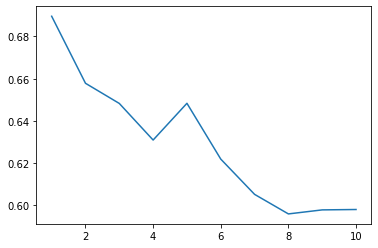

In [31]:
plt.plot(np.arange(10)+1,train_losses)
plt.show()

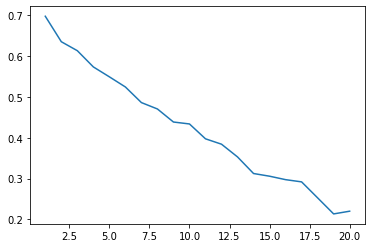

In [33]:
plt.plot(np.arange(20)+1, avg_losses)
plt.show()